In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [4]:
import cv2
import os
import matplotlib.pyplot as plt
import numpy as np

from scipy.ndimage import gaussian_filter


# Impotting the data

In [2]:
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="vdwZqnGpjgyGRFaqYIwX")
project = rf.workspace("weapondetection-mqgm5").project("weapon-detection-cabwp")
version = project.version(3)
dataset = version.download("yolov8")
                

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.3/87.3 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 34.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 55.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 58.0 MB/s eta 0:00:00:00:0100:01
  Attempting uninstall: idna
    Found existing installation: idna 3.10
    Uninstalling idna-3.10:
      Successfully uninstalled idna-3.10
  Attempting uninstall: opencv-python-headless
    Found existing installation: opencv-python-headless 4.11.0.86
    Uninstalling opencv-python-headless-4.11.0.86:
      Successfully uninstalled opencv-python-headless-4.11.0.86
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 2.8.0 requires google-cloud-bigquer


Extracting Dataset Version Zip to weapon-detection-3 in yolov8:: 100%|██████████| 31974/31974 [00:04<00:00, 7146.71it/s] 


# Preprocessing

In [5]:
images_dir = "/kaggle/working/weapon-detection-3/train/images"
labels_dir = "/kaggle/working/weapon-detection-3/train/labels"
def clean_labels(path):
   
    for file in os.listdir(labels_dir):
        label_path = os.path.join(labels_dir, file)
        with open(label_path, "r") as f:
            lines = f.readlines()

        clean_lines = [line for line in lines if len(line.strip().split()) == 5]

        with open(label_path, "w") as f:
            f.writelines(clean_lines)

        if os.path.getsize(label_path) == 0:
            os.remove(label_path)
            img_name_jpg = file.replace(".txt", ".jpg")
            img_name_png = file.replace(".txt", ".png")

            for img_name in [img_name_jpg, img_name_png]:
                img_path = os.path.join(images_dir, img_name)
                if os.path.exists(img_path):
                    os.remove(img_path)

base_path = "/kaggle/working/weapon-detection-3"
clean_labels(os.path.join(base_path, "train"))
clean_labels(os.path.join(base_path, "valid"))



In [6]:
after_count = len(os.listdir(images_dir))

print(f"Num of images after cleaning: {after_count}")

Num of images after cleaning: 12628


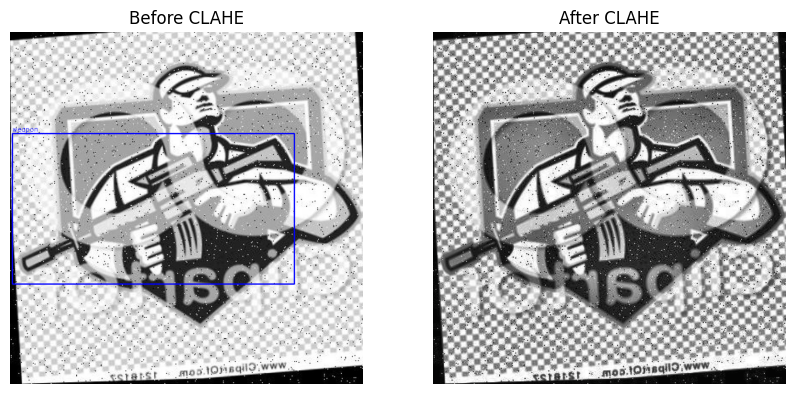

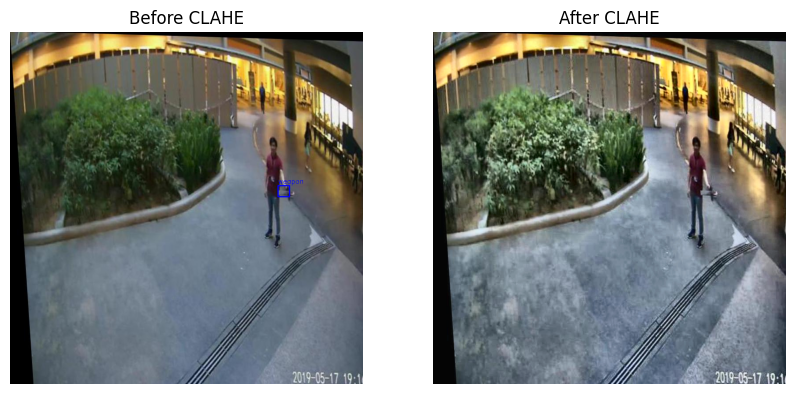

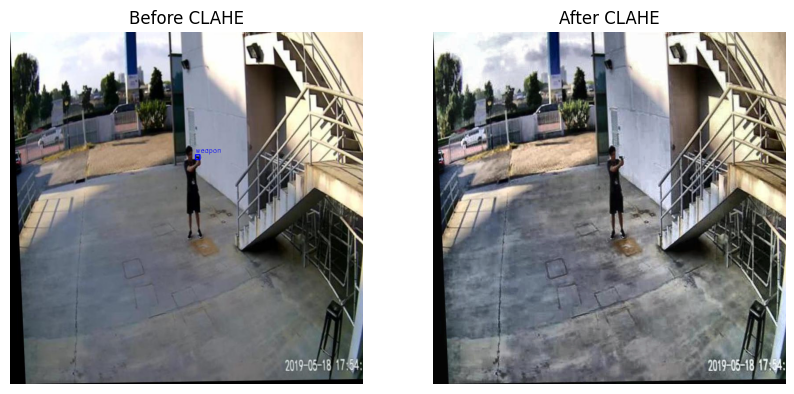

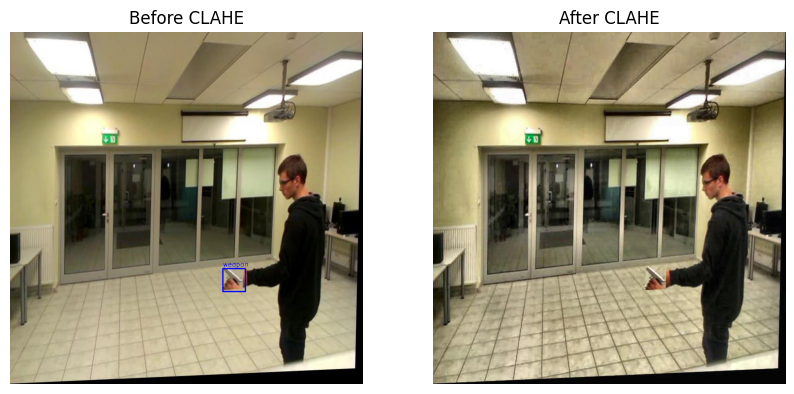

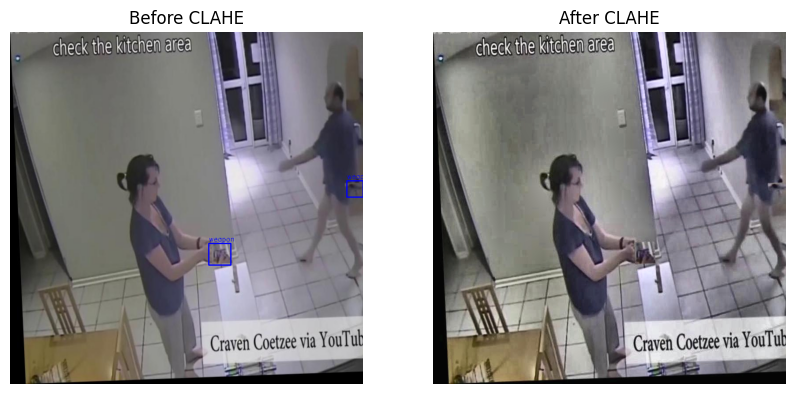

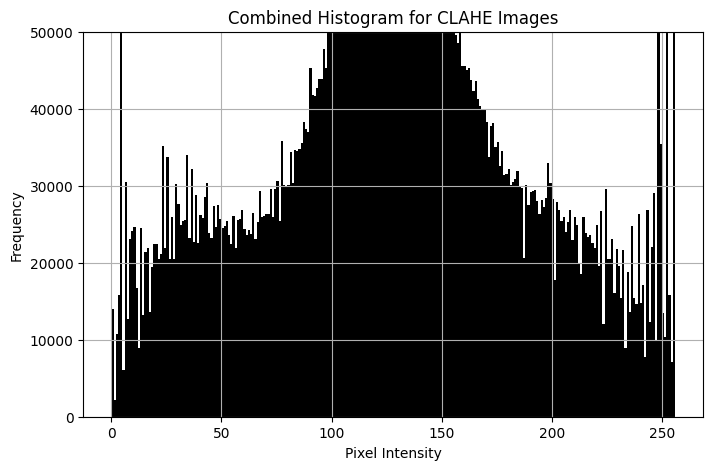

In [8]:
def apply_CLAHE(img, clip_limit=2.0, tile_grid_size=(8, 8)):
    lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
    l, a, b = cv2.split(lab)
    
    clahe = cv2.createCLAHE(clipLimit=clip_limit, tileGridSize=tile_grid_size)
    cl = clahe.apply(l)
    
    merged = cv2.merge((cl, a, b))
    img_clahe = cv2.cvtColor(merged, cv2.COLOR_LAB2BGR)
    return img_clahe

all_pixels = []  

for img_file in os.listdir(images_dir)[65:70]:
    img_path = os.path.join(images_dir, img_file)
    label_path = os.path.join(labels_dir, img_file.replace(".jpg", ".txt"))
    
    img = cv2.imread(img_path)
    if img is None:
        continue
    
    h, w = img.shape[:2]
    img_clahe = apply_CLAHE(img, clip_limit=2.5, tile_grid_size=(8, 8))
    
    if os.path.exists(label_path):
        with open(label_path, "r") as f:
            for line in f:
                cls, x, y, bw, bh = map(float, line.split())
                x1 = int((x - bw/2) * w)
                y1 = int((y - bh/2) * h)
                x2 = int((x + bw/2) * w)
                y2 = int((y + bh/2) * h)
                cv2.rectangle(img, (x1, y1), (x2, y2), (255, 0, 0), 2)
                cv2.putText(img, "weapon", (x1, y1-5),
                            cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 1)

    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_clahe_rgb = cv2.cvtColor(img_clahe, cv2.COLOR_BGR2RGB)
    
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(img_rgb)
    plt.title("Before CLAHE")
    plt.axis("off")
    
    plt.subplot(1, 2, 2)
    plt.imshow(img_clahe_rgb)
    plt.title("After CLAHE")
    plt.axis("off")
    
    plt.show()
    
    all_pixels.extend(img_clahe.flatten())

all_pixels = np.array(all_pixels)

plt.figure(figsize=(8, 5))
plt.hist(all_pixels, bins=256, range=(0, 256), color='black')
plt.title("Combined Histogram for CLAHE Images")
plt.xlabel("Pixel Intensity")
plt.ylabel("Frequency")
plt.ylim(0, 50000)
plt.grid(True)
plt.show()


 Frequency is unbalanced

# Trying with Gaussian blur

In [9]:
blurred_cv = cv2.GaussianBlur(img_clahe, (5,5), sigmaX=2)


# Builduing the model

In [12]:
pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 22.0 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 91.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 65.3 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 44.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.3 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 1.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 25.7 MB/s eta 0:00:0000:0100:01m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.3 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 87.3 MB/s eta 0:00:00:00:0100:01
  Attempting uninstall

In [13]:
from ultralytics import YOLO

model = YOLO("yolov8n.pt") 
model.train(data="/kaggle/working/weapon-detection-3/data.yaml",
            epochs=50,
            batch=8,
            imgsz=768, 
            lr0=0.01,                             
            optimizer='SGD',
            save_period=5,
            project="/kaggle/working/Outpuف",
            freeze=5
)


            
            

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


Ultralytics 8.3.177 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/kaggle/working/weapon-detection-3/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=5, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=768, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train, nbs=64, nms=False, opset=None, optimize=False, optimizer=SGD, overlap_mask=True, patience=100, perspective=0.0, plots=True

Overriding model.yaml nc=80 with nc=1

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics

AMP: checks passed ✅
train: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1621.3±719.3 MB/s, size: 61.3 KB)


train: Scanning /kaggle/working/weapon-detection-3/train/labels... 12628 images, 0 backgrounds, 0 corrupt: 100%|██████████| 12628/12628 [00:08<00:00, 1507.11it/s]


train: New cache created: /kaggle/working/weapon-detection-3/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 649.9±519.2 MB/s, size: 71.8 KB)


val: Scanning /kaggle/working/weapon-detection-3/valid/labels... 1578 images, 114 backgrounds, 0 corrupt: 100%|██████████| 1578/1578 [00:01<00:00, 1394.78it/s]

val: New cache created: /kaggle/working/weapon-detection-3/valid/labels.cache
WARNING ⚠️ Box and segment counts should be equal, but got len(segments) = 6, len(boxes) = 1761. To resolve this only boxes will be used and all segments will be removed. To avoid this please supply either a detect or segment dataset, not a detect-segment mixed dataset.


Plotting labels to /kaggle/working/Outpuف/train/labels.jpg... 
optimizer: SGD(lr=0.01, momentum=0.937) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 768 train, 768 val
Using 4 dataloader workers
Logging results to /kaggle/working/Outpuف/train
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50       1.1G      1.827      2.471      1.792         12        768: 100%|██████████| 1579/1579 [02:58<00:00,  8.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 99/99 [00:12<00:00,  8.17it/s]


                   all       1578       1761      0.496      0.391      0.401      0.176

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50      1.36G      1.783      1.927      1.722          7        768: 100%|██████████| 1579/1579 [02:50<00:00,  9.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 99/99 [00:10<00:00,  9.22it/s]


                   all       1578       1761      0.586      0.426       0.41      0.185

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50      1.37G      1.841      1.961       1.77          6        768: 100%|██████████| 1579/1579 [02:47<00:00,  9.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 99/99 [00:10<00:00,  9.24it/s]


                   all       1578       1761      0.545      0.369      0.399      0.181

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50      1.38G      1.857      1.952      1.801          6        768: 100%|██████████| 1579/1579 [02:47<00:00,  9.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 99/99 [00:10<00:00,  9.16it/s]


                   all       1578       1761      0.612      0.397      0.456      0.209

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50      1.39G      1.781      1.845       1.75          7        768: 100%|██████████| 1579/1579 [02:46<00:00,  9.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 99/99 [00:10<00:00,  9.09it/s]


                   all       1578       1761      0.651      0.464      0.519      0.244

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50      1.41G      1.745      1.754      1.716          7        768: 100%|██████████| 1579/1579 [02:47<00:00,  9.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 99/99 [00:10<00:00,  9.27it/s]


                   all       1578       1761      0.641      0.458        0.5      0.248

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50      1.42G      1.704      1.672      1.681          7        768: 100%|██████████| 1579/1579 [02:46<00:00,  9.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 99/99 [00:10<00:00,  9.21it/s]


                   all       1578       1761      0.696      0.505      0.581      0.274

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50      1.43G      1.673      1.614      1.662          9        768: 100%|██████████| 1579/1579 [02:47<00:00,  9.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 99/99 [00:10<00:00,  9.26it/s]


                   all       1578       1761       0.73      0.496      0.574      0.286

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50      1.44G      1.641      1.561      1.631         10        768: 100%|██████████| 1579/1579 [02:47<00:00,  9.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 99/99 [00:10<00:00,  9.01it/s]


                   all       1578       1761      0.714      0.531      0.608      0.309

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50      1.45G      1.618      1.523      1.614         10        768: 100%|██████████| 1579/1579 [02:47<00:00,  9.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 99/99 [00:10<00:00,  9.17it/s]


                   all       1578       1761      0.731      0.539      0.622      0.316

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50      1.46G      1.596      1.466      1.584          6        768: 100%|██████████| 1579/1579 [02:48<00:00,  9.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 99/99 [00:11<00:00,  8.98it/s]


                   all       1578       1761      0.759      0.527      0.623      0.323

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50      1.47G      1.578      1.448      1.573         10        768: 100%|██████████| 1579/1579 [02:47<00:00,  9.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 99/99 [00:10<00:00,  9.26it/s]


                   all       1578       1761      0.761       0.56      0.646      0.338

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50      1.48G      1.555       1.41      1.562          4        768: 100%|██████████| 1579/1579 [02:48<00:00,  9.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 99/99 [00:10<00:00,  9.12it/s]

                   all       1578       1761      0.745      0.573       0.66      0.347



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50      1.49G       1.55       1.39      1.545          3        768: 100%|██████████| 1579/1579 [02:47<00:00,  9.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 99/99 [00:10<00:00,  9.25it/s]


                   all       1578       1761      0.766      0.574      0.669      0.351

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50      1.51G      1.522      1.362      1.534          6        768: 100%|██████████| 1579/1579 [02:47<00:00,  9.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 99/99 [00:10<00:00,  9.12it/s]


                   all       1578       1761      0.783      0.581      0.669      0.358

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50      1.52G      1.507      1.326       1.52          8        768: 100%|██████████| 1579/1579 [02:47<00:00,  9.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 99/99 [00:10<00:00,  9.10it/s]


                   all       1578       1761      0.757        0.6      0.683      0.365

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50      1.53G      1.502       1.31      1.503         11        768: 100%|██████████| 1579/1579 [02:48<00:00,  9.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 99/99 [00:10<00:00,  9.04it/s]


                   all       1578       1761      0.773      0.605      0.691      0.377

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50      1.54G       1.49      1.288        1.5          9        768: 100%|██████████| 1579/1579 [02:48<00:00,  9.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 99/99 [00:10<00:00,  9.11it/s]


                   all       1578       1761      0.802      0.618      0.714      0.387

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50      1.55G      1.482      1.285      1.488          9        768: 100%|██████████| 1579/1579 [02:49<00:00,  9.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 99/99 [00:10<00:00,  9.12it/s]


                   all       1578       1761      0.794      0.615      0.707      0.377

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50      1.56G      1.457      1.258      1.473          8        768: 100%|██████████| 1579/1579 [02:49<00:00,  9.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 99/99 [00:10<00:00,  9.07it/s]


                   all       1578       1761      0.786       0.63      0.716      0.391

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50      1.57G      1.452      1.246      1.466          4        768: 100%|██████████| 1579/1579 [02:48<00:00,  9.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 99/99 [00:10<00:00,  9.20it/s]


                   all       1578       1761      0.813      0.654       0.73      0.396

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50      1.59G      1.435      1.217      1.455          5        768: 100%|██████████| 1579/1579 [02:47<00:00,  9.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 99/99 [00:10<00:00,  9.22it/s]


                   all       1578       1761      0.795      0.651      0.723      0.397

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50       1.6G      1.426      1.193      1.449          8        768: 100%|██████████| 1579/1579 [02:48<00:00,  9.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 99/99 [00:10<00:00,  9.23it/s]


                   all       1578       1761      0.811      0.648      0.736      0.404

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50      1.61G      1.417      1.187      1.437         11        768: 100%|██████████| 1579/1579 [02:48<00:00,  9.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 99/99 [00:10<00:00,  9.14it/s]

                   all       1578       1761      0.809       0.66      0.745      0.411



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50      1.62G      1.423      1.186      1.437         11        768: 100%|██████████| 1579/1579 [02:47<00:00,  9.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 99/99 [00:10<00:00,  9.11it/s]

                   all       1578       1761      0.821      0.667      0.755       0.42



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50      1.63G      1.395      1.155       1.42         12        768: 100%|██████████| 1579/1579 [02:47<00:00,  9.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 99/99 [00:10<00:00,  9.18it/s]


                   all       1578       1761      0.814      0.675      0.762       0.42

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50      1.64G      1.393      1.139      1.418          8        768: 100%|██████████| 1579/1579 [02:48<00:00,  9.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 99/99 [00:10<00:00,  9.20it/s]


                   all       1578       1761       0.81      0.677      0.762      0.423

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50      1.65G      1.382      1.126      1.413          9        768: 100%|██████████| 1579/1579 [02:47<00:00,  9.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 99/99 [00:10<00:00,  9.35it/s]


                   all       1578       1761      0.797      0.682      0.762      0.426

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50      1.67G      1.382      1.119      1.407         10        768: 100%|██████████| 1579/1579 [02:50<00:00,  9.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 99/99 [00:10<00:00,  9.07it/s]


                   all       1578       1761      0.801      0.685      0.769      0.429

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50      1.68G      1.359      1.092      1.391          9        768: 100%|██████████| 1579/1579 [02:48<00:00,  9.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 99/99 [00:10<00:00,  9.20it/s]

                   all       1578       1761      0.822      0.692      0.777      0.439



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50      1.69G      1.356      1.089      1.388          8        768: 100%|██████████| 1579/1579 [02:47<00:00,  9.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 99/99 [00:10<00:00,  9.34it/s]


                   all       1578       1761      0.826      0.697      0.784      0.438

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50       1.7G      1.343      1.061      1.382          9        768: 100%|██████████| 1579/1579 [02:47<00:00,  9.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 99/99 [00:10<00:00,  9.17it/s]

                   all       1578       1761      0.826      0.702      0.779      0.437



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50      1.71G      1.333      1.049      1.369          9        768: 100%|██████████| 1579/1579 [02:49<00:00,  9.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 99/99 [00:10<00:00,  9.15it/s]


                   all       1578       1761      0.841      0.705      0.789      0.448

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50      1.72G      1.322       1.04      1.371          7        768: 100%|██████████| 1579/1579 [02:50<00:00,  9.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 99/99 [00:11<00:00,  8.93it/s]

                   all       1578       1761      0.839      0.708      0.791      0.444



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50      1.73G      1.317      1.035      1.353          7        768: 100%|██████████| 1579/1579 [02:49<00:00,  9.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 99/99 [00:10<00:00,  9.07it/s]


                   all       1578       1761       0.84      0.719      0.801      0.454

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50      1.74G      1.313      1.032      1.351          4        768: 100%|██████████| 1579/1579 [02:49<00:00,  9.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 99/99 [00:11<00:00,  8.98it/s]


                   all       1578       1761      0.845      0.719      0.797      0.453

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50      1.76G      1.291      1.011      1.338          7        768: 100%|██████████| 1579/1579 [02:50<00:00,  9.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 99/99 [00:10<00:00,  9.13it/s]


                   all       1578       1761      0.823      0.721      0.793      0.454

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50      1.77G      1.293      1.008      1.341          7        768: 100%|██████████| 1579/1579 [02:50<00:00,  9.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 99/99 [00:10<00:00,  9.15it/s]


                   all       1578       1761       0.84      0.726      0.799      0.457

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50      1.78G       1.28     0.9875      1.333          7        768: 100%|██████████| 1579/1579 [02:49<00:00,  9.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 99/99 [00:10<00:00,  9.01it/s]


                   all       1578       1761      0.857      0.726      0.804      0.459

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50      1.79G      1.277     0.9775      1.328          5        768: 100%|██████████| 1579/1579 [02:51<00:00,  9.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 99/99 [00:10<00:00,  9.03it/s]


                   all       1578       1761       0.85      0.732      0.807      0.458
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50       1.8G      1.286     0.8546      1.318          4        768: 100%|██████████| 1579/1579 [02:49<00:00,  9.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 99/99 [00:10<00:00,  9.07it/s]


                   all       1578       1761      0.837      0.733      0.807      0.462

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50      1.81G      1.262     0.8202      1.298          4        768: 100%|██████████| 1579/1579 [02:46<00:00,  9.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 99/99 [00:10<00:00,  9.21it/s]


                   all       1578       1761      0.844       0.72      0.804      0.463

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50      1.82G      1.244     0.8054      1.293          4        768: 100%|██████████| 1579/1579 [02:45<00:00,  9.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 99/99 [00:10<00:00,  9.31it/s]


                   all       1578       1761      0.841      0.736      0.808      0.469

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50      1.83G      1.241     0.7982      1.289          4        768: 100%|██████████| 1579/1579 [02:45<00:00,  9.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 99/99 [00:10<00:00,  9.21it/s]


                   all       1578       1761      0.845      0.735       0.81       0.47

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50      1.84G      1.217     0.7777      1.269          4        768: 100%|██████████| 1579/1579 [02:45<00:00,  9.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 99/99 [00:10<00:00,  9.29it/s]

                   all       1578       1761      0.852      0.738      0.813      0.474



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50      1.86G      1.212      0.769      1.267          7        768: 100%|██████████| 1579/1579 [02:45<00:00,  9.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 99/99 [00:10<00:00,  9.15it/s]


                   all       1578       1761      0.846      0.734      0.815      0.478

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50      1.87G      1.194     0.7599      1.261          5        768: 100%|██████████| 1579/1579 [02:45<00:00,  9.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 99/99 [00:10<00:00,  9.14it/s]

                   all       1578       1761      0.854      0.728      0.815      0.475



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50      1.88G      1.189     0.7452      1.246          4        768: 100%|██████████| 1579/1579 [02:45<00:00,  9.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 99/99 [00:10<00:00,  9.04it/s]

                   all       1578       1761      0.862       0.74      0.819      0.475



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50      1.89G      1.178     0.7374      1.245          5        768: 100%|██████████| 1579/1579 [02:44<00:00,  9.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 99/99 [00:10<00:00,  9.26it/s]


                   all       1578       1761      0.858      0.742      0.819      0.477

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50       1.9G      1.167     0.7276      1.235          4        768: 100%|██████████| 1579/1579 [02:45<00:00,  9.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 99/99 [00:10<00:00,  9.15it/s]


                   all       1578       1761      0.847      0.746      0.818      0.477

50 epochs completed in 2.490 hours.
Optimizer stripped from /kaggle/working/Outpuف/train/weights/last.pt, 6.3MB
Optimizer stripped from /kaggle/working/Outpuف/train/weights/best.pt, 6.3MB

Validating /kaggle/working/Outpuف/train/weights/best.pt...
Ultralytics 8.3.177 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
Model summary (fused): 72 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 99/99 [00:12<00:00,  8.16it/s]
invalid value encountered in less
invalid value encountered in less


                   all       1578       1761      0.851      0.745      0.819      0.477
Speed: 0.2ms preprocess, 2.9ms inference, 0.0ms loss, 1.6ms postprocess per image
Results saved to /kaggle/working/Outpuف/train


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x795f5d454390>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.048048, 

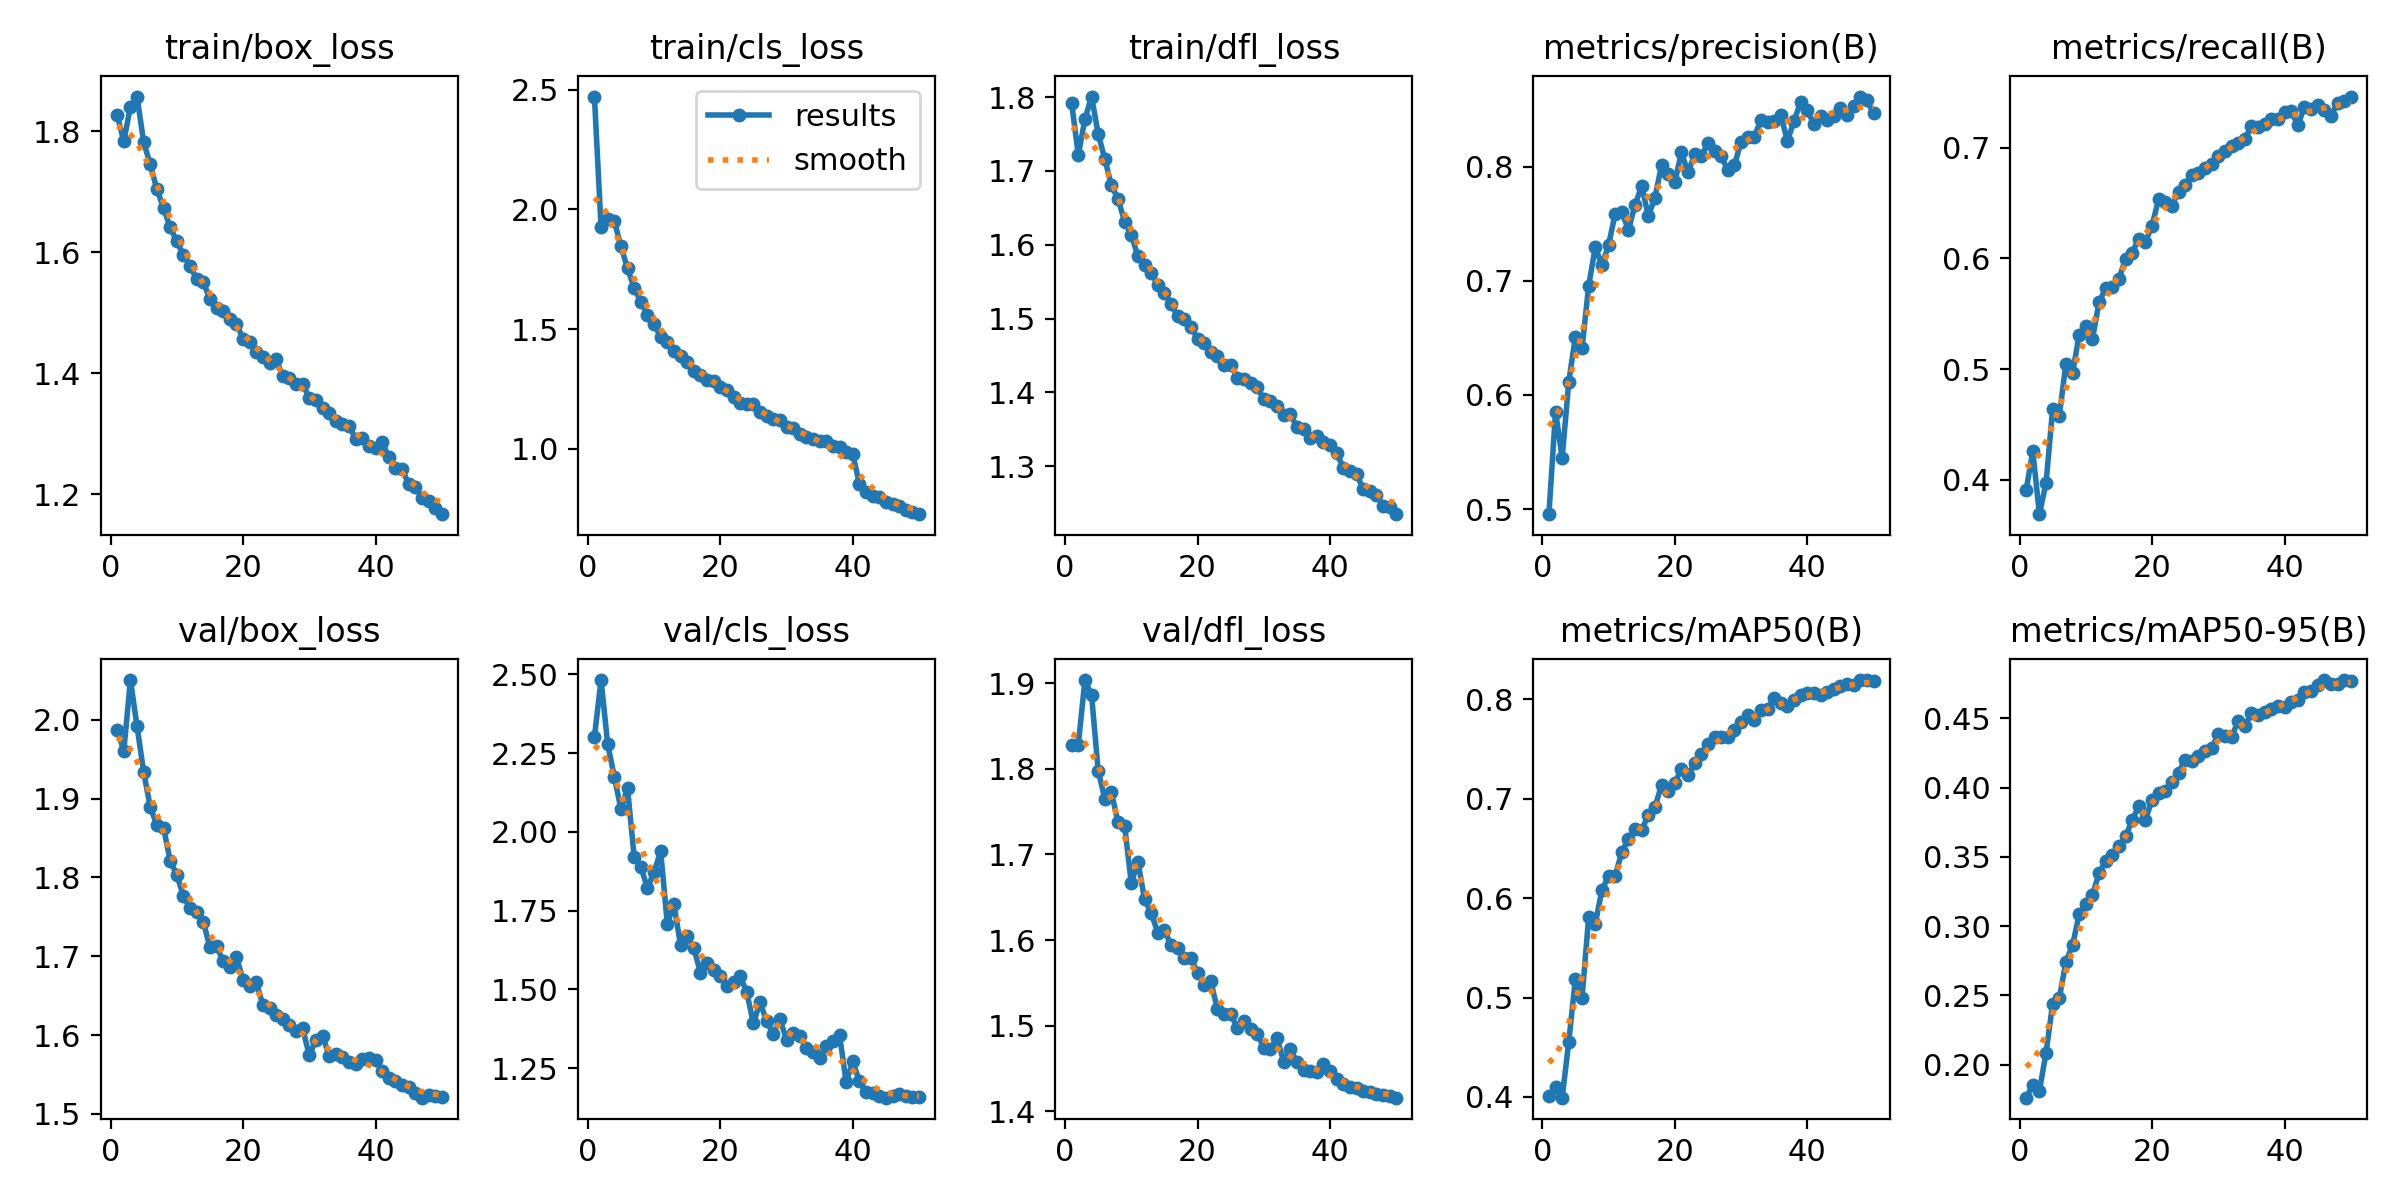

In [22]:
from IPython.display import Image
Image(filename='/kaggle/working/Outpuف/train/results.png',width=900)

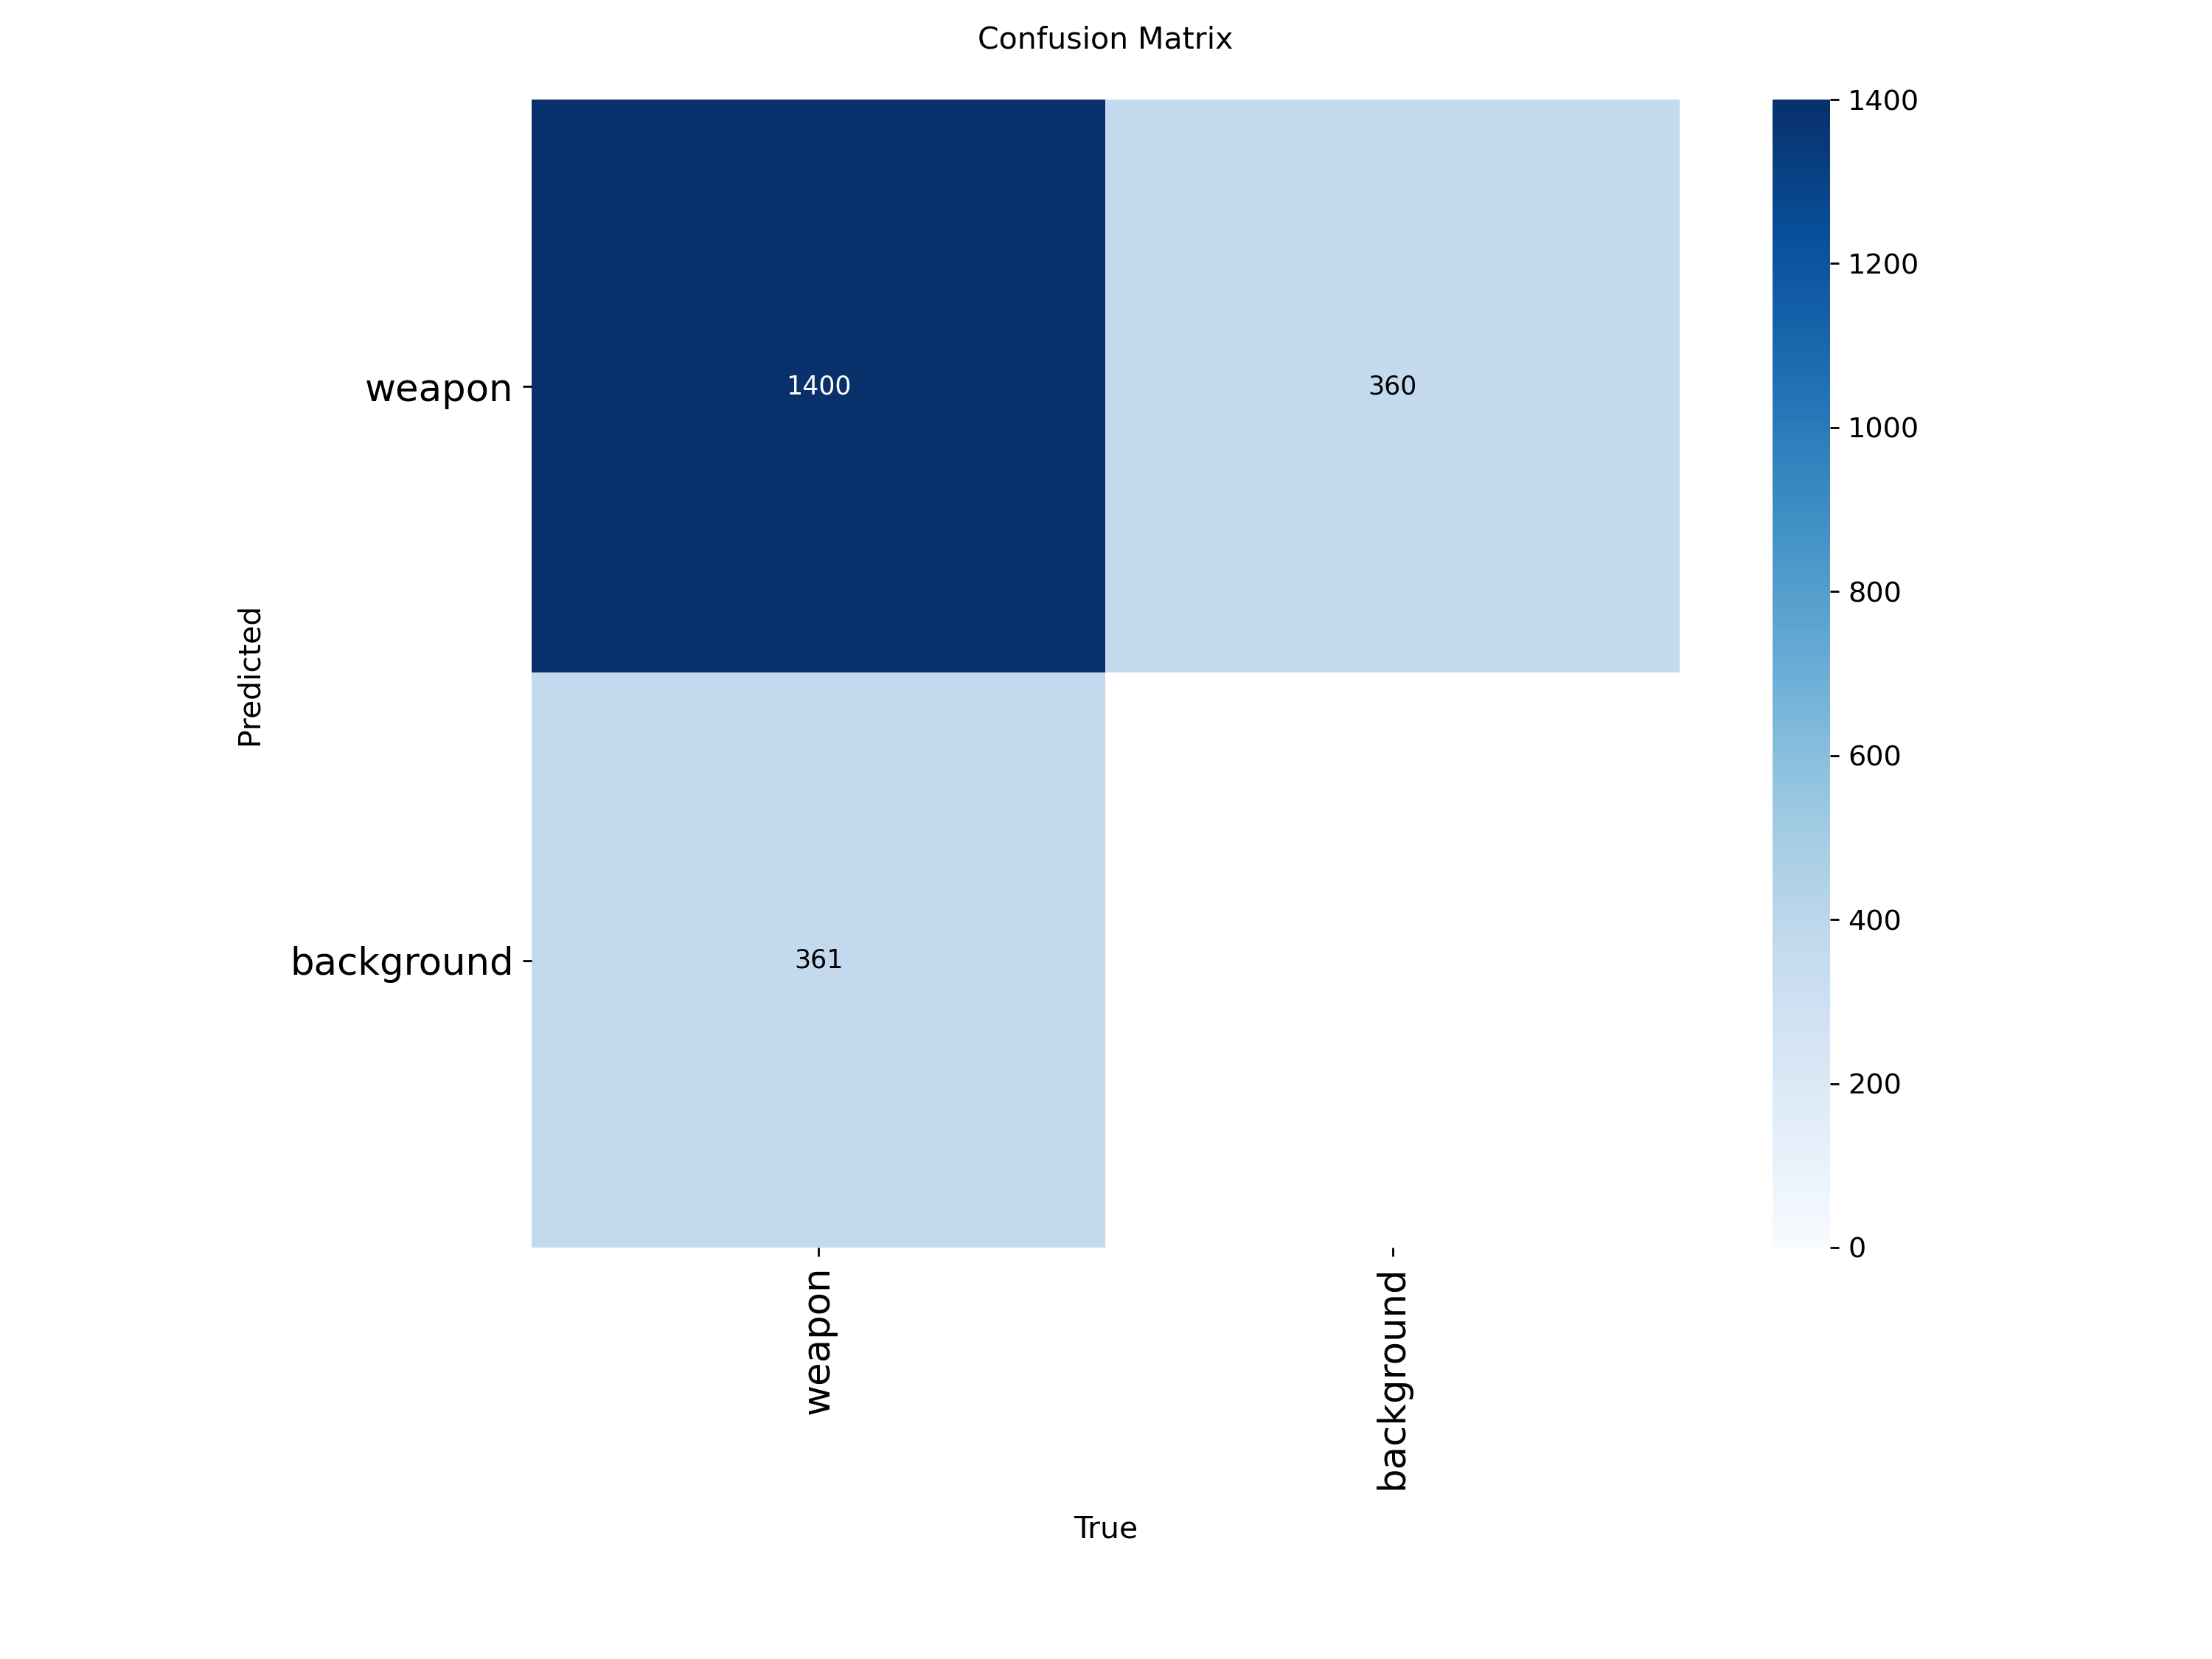

In [23]:
Image(filename="/kaggle/working/Outpuف/train/confusion_matrix.png",width=900)

In [25]:
my_model=YOLO('/kaggle/working/Outpuف/train/weights/best.pt')


image 1/1 /kaggle/working/weapon-detection-3/test/images/gmd_1_frame13_jpg.rf.6cdccdf8b298cd303bd9070877b96e2d.jpg: 768x768 1 weapon, 7.2ms
Speed: 6.1ms preprocess, 7.2ms inference, 1.6ms postprocess per image at shape (1, 3, 768, 768)
Results saved to runs/detect/predict


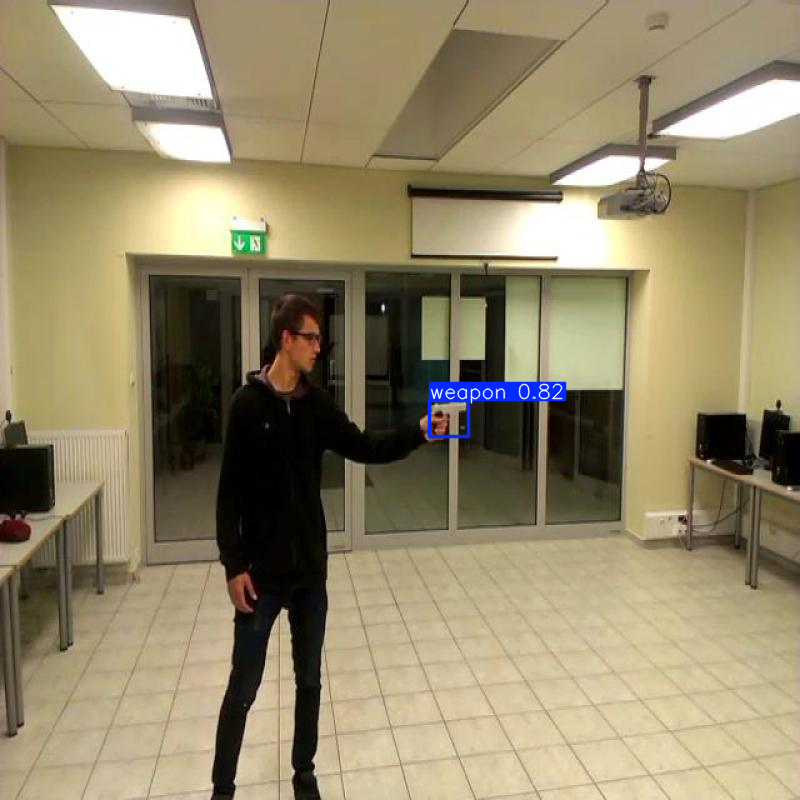

In [26]:
testing=my_model.predict("/kaggle/working/weapon-detection-3/test/images/gmd_1_frame13_jpg.rf.6cdccdf8b298cd303bd9070877b96e2d.jpg",
                conf=.5,
                save=True)
testing[0].show()



image 1/1 /kaggle/working/weapon-detection-3/test/images/mgd_custom_frame1544_jpg.rf.296593fdde8b26b7369ae771b8278652.jpg: 768x768 1 weapon, 8.6ms
Speed: 5.0ms preprocess, 8.6ms inference, 1.5ms postprocess per image at shape (1, 3, 768, 768)
Results saved to runs/detect/predict


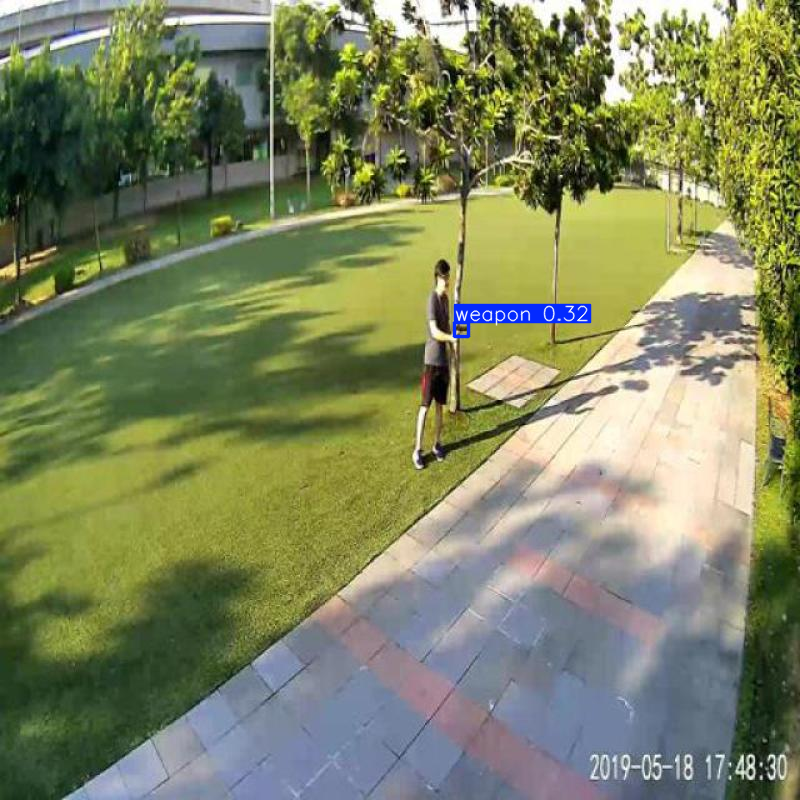

In [ ]:
testing2=my_model.predict("/kaggle/working/weapon-detection-3/test/images/mgd_custom_frame1544_jpg.rf.296593fdde8b26b7369ae771b8278652.jpg",
                conf=.3,
                save=True)
testing2[0].show()


image 1/1 /kaggle/working/weapon-detection-3/test/images/mgd_custom_frame872_jpg.rf.26aff949e6a933f5d5d31b992a3cb63d.jpg: 768x768 1 weapon, 8.4ms
Speed: 3.8ms preprocess, 8.4ms inference, 1.9ms postprocess per image at shape (1, 3, 768, 768)
Results saved to runs/detect/predict


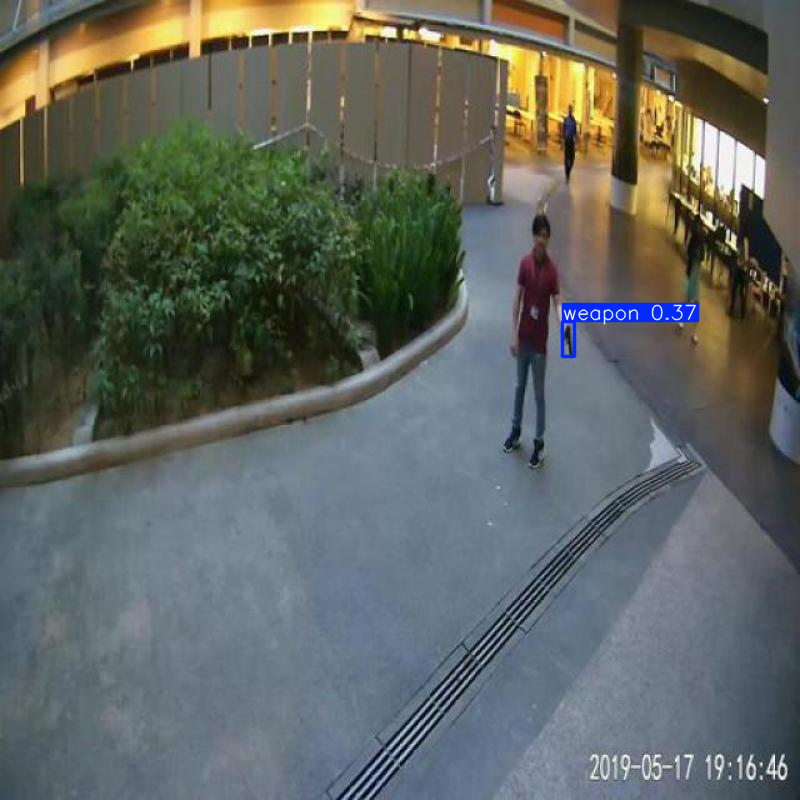

In [36]:
testing2=my_model.predict("/kaggle/working/weapon-detection-3/test/images/mgd_custom_frame872_jpg.rf.26aff949e6a933f5d5d31b992a3cb63d.jpg",
                conf=.3,
                save=True)
testing2[0].show()


image 1/1 /kaggle/working/weapon-detection-3/test/images/mgd_custom_frame2190_jpg.rf.408259de4e68ca29c5621774adfc6d79.jpg: 768x768 1 weapon, 7.5ms
Speed: 3.9ms preprocess, 7.5ms inference, 1.6ms postprocess per image at shape (1, 3, 768, 768)
Results saved to runs/detect/predict


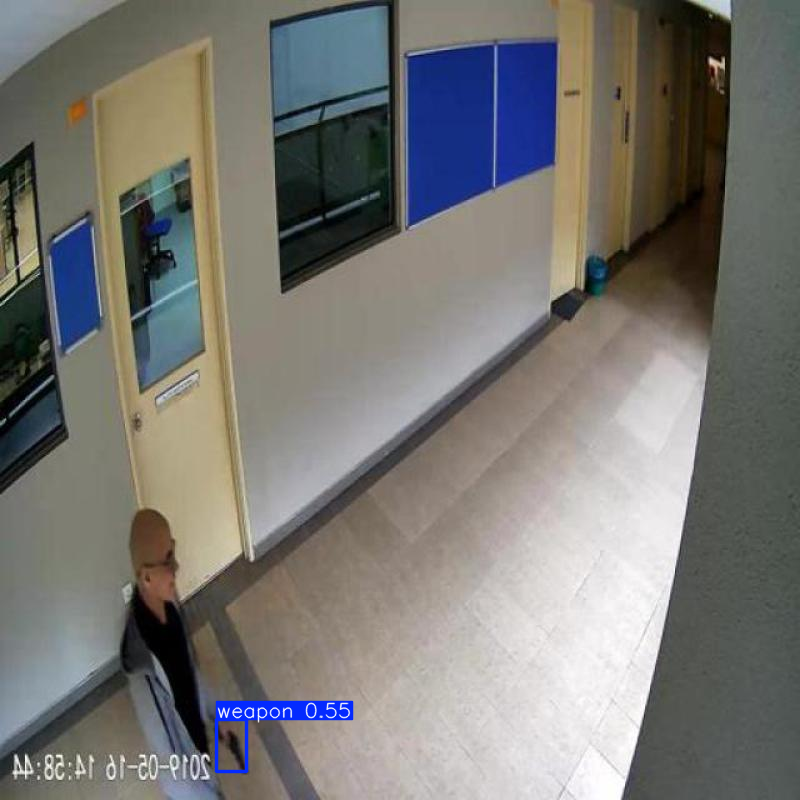

In [45]:
testing2=my_model.predict("/kaggle/working/weapon-detection-3/test/images/mgd_custom_frame2190_jpg.rf.408259de4e68ca29c5621774adfc6d79.jpg",
                conf=.25,
                save=True)
testing2[0].show()